# Training a Reinforcement Learning Agent with Double Deep Q Network for Super Mario Bros

The purpose of this research is to implement the current state of
the art in Double DQN and evaluate its performance in a famous
game such as Super Mario Bros. We will be using the gym-super-mario-bros environment, which is built on top
of the OpenAI gym library. A state of the game is represented by
a list of 4 consecutive frames of 240 × 256 × 3 (height × width ×
3 channels RGB). The size of the action space in this game is 256
which corresponds to 256 possible actions of the character.

The research will show the benefits of using CNN in complex and high-dimensional problems in
Artificial Intelligence. Then, the Double DQN will be presented to
deal with some of the deficiencies of CNN in DQN so that the agent
can learn better policies and maximize the rewards.



In [1]:
# Install mario bross gym envirnoment
!pip install gym-super-mario-bros


     |████████████████████████████████| 204kB 8.5MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
  Created wheel for nes-py: filename=nes_py-8.1.6-cp36-cp36m-linux_x86_64.whl size=437776 sha256=5e246b3dcd6d542b239f30253b32809b2708225b6fa58ae9c44aacd851d68787
  Stored in directory: /root/.cache/pip/wheels/a7/56/af/b84114d31ea6301a5c4651fb048bd6072646596a6ceb3bbc24
Successfully built nes-py
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [2]:
# Main Libraries

# Mario Bross environment
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY
import gym
from nes_py.wrappers import JoypadSpace

# Deep Learning
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F

# Utilities
import random
from tqdm import tqdm
import pickle 
import numpy as np
import collections 
import cv2
import time
import statistics

# Graphic
from IPython import display
import matplotlib.pyplot as plt

import torch.nn.functional as nnf
print(torch.cuda.device_count())
device = torch.device('cuda:0')

# Resnet - Transfer Learning
from torchvision import models

# Download CSV from Collab
import pandas as pd
from google.colab import files


1


## Pre processing class for SuperMarioBross gym

We have performed several pre-processingsteps to make the training faster and increase the quality of the agents

1. The joypad is always set to RIGHT to reduce the size of theaction space
2. Resize the frames to 84x84 grayscale images
3. Normalize pixel values to [0,1]
4. Use the same action for 4 consecutive steps
5. Return the max of 2 most recent observations

In [3]:
class SkipAndMax(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """
          1. Take the same action for 'skip' number of obs
          2. Return the max of 2 most recent obs
        """
        super(SkipAndMax, self).__init__(env)
        self.obs_buffer = collections.deque(maxlen=2) # 2 most recent observations
        self._skip = skip # Use the same action for 'skip' number of obs

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self.obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        
        # Take max of 2 most recent obs
        max_frame = np.max(np.stack(self.obs_buffer), axis=0) 

        return max_frame, total_reward, done, info

    def reset(self):
        self.obs_buffer.clear() # Clear obs buffer
        obs = self.env.reset()
        self.obs_buffer.append(obs) # Append initial obs
        return obs


class Frame_Processing(gym.ObservationWrapper):
    """
      Downsamples to 84x84 => Greyscales
    """
    def __init__(self, env=None):
        super(Frame_Processing, self).__init__(env)
        old_shape = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8).shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)
    def observation(self, obs):
        obs = Frame_Processing.process(obs)
        return np.moveaxis(obs, 2, 0) # Image to Pytorch

    @staticmethod
    def process(frame):
        # Check input frame size
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Wrong resolution."

        # Converting a colored RGB image into a grayscale image
        # Formula: Y = 0.299R + 0.587G + 0.114B
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        
        # Resize to 84*84
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

class BufferingWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferingWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return np.array(self.buffer).astype(np.float32) / 255.0 # Normalize pixel values in frame --> 0 to 1

## Mario Bros Environment

The MarioBrossEnvironment class manages the main functions of the environment interaction

In [4]:
## Implemented according
class MarioBrossEnvironment:
  def __init__(self, skip = 4, buffer_step = 4):
      # Initialize and wrap the environment
      self.env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
      self.env = SkipAndMax(self.env)
      self.env = Frame_Processing(self.env)
      self.env = BufferingWrapper(self.env, 4)
      self.env = JoypadSpace(self.env, RIGHT_ONLY) 

      self.env.seed(500)
      self.nb_step = 0
      self.observation_space_final = self.env.observation_space.shape
      self.action_space = self.env.action_space.n
  
  def sample_action(self):
        return self.env.action_space.sample()

  def reset(self):
      self.nb_step = 0
      state = self.env.reset()
      state = torch.unsqueeze(torch.tensor(state),0)
      return state

  def step(self,action):
      state, reward, done, info = self.env.step(action)
      state = torch.unsqueeze(torch.tensor(state),0)
      return state, reward, done, info

  def render(self):
        self.env.render()

  def close(self):
        self.env.close()

  def show_state(self,info=""):
        plt.figure(3)
        plt.clf()
        plt.imshow(self.env.render(mode='rgb_array'))
        plt.title("Episode: %d %s" % (self.nb_step, info))
        plt.axis('off')

        display.clear_output(wait=True)
        display.display(plt.gcf())



## Deep Neural Network: Convolutional Neural Network Architectures

The objective is to analyze what architectures wor kbetter for this learning environment.

a) The Classic CNN contains 3 convolution layers and 1 linear hidden layer with RELU activation both.

b) The Deeper CNN adds 2 more convolutional layers to (a). 

c) The Wider CNN doubles the number of filters in the convolutional layers of (a). 

d) By last, theMaxPooling CNN (adds max pooling after the RELU activationof each convolutional layers in (a)

### Classic Convolutional Neural Network 
The Classic CNN contains 3 convolution layers and 1 linear hidden layer with RELU activation both

In [5]:
# Basic CNN
class Classic_ConvNet(nn.Module):
  def __init__(self, input_size, n_actions):
        super(Classic_ConvNet, self).__init__()
        self.input_size = input_size
        self.output_size = n_actions

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_size[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self.getShapeAfterConvolutions(self.input_size)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.output_size)
        )
    
  def getShapeAfterConvolutions(self, shape):
      o = self.conv(torch.zeros(1, *shape))
      return int(np.prod(o.size()))

  def forward(self, x):
      conv_out = self.conv(x)
      conv_out=conv_out.view(x.size()[0], -1)
      return self.fc(conv_out)


### Deep Convolutional Network
The Deeper CNN adds 2 more convolutional layers to (a) resulting in 5 Convolutional layers 

In [6]:
# Deeper CNN: More CNN layers and linear layers
class Deeper_ConvNet(nn.Module):
  def __init__(self, input_size, n_actions):
        super(Deeper_ConvNet, self).__init__()
        self.input_size = input_size
        self.output_size = n_actions

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_size[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self.getShapeAfterConvolutions(self.input_size)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.output_size)
        )
    
  def getShapeAfterConvolutions(self, shape):
      o = self.conv(torch.zeros(1, *shape))
      return int(np.prod(o.size()))

  def forward(self, x):
      conv_out = self.conv(x)
      conv_out=conv_out.view(x.size()[0], -1)
      return self.fc(conv_out)

### Wider Convolutional Netowrk
The Wider CNN doubles the number of filters in the convolutional layers of (a)

In [7]:
# Wider CNN: More Neurons
class Wider_ConvNet(nn.Module):
  def __init__(self, input_size, n_actions):
        super(Wider_ConvNet, self).__init__()
        self.input_size = input_size
        self.output_size = n_actions

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_size[0], 64, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self.getShapeAfterConvolutions(self.input_size)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.output_size)
        )
    
  def getShapeAfterConvolutions(self, shape):
      o = self.conv(torch.zeros(1, *shape))
      return int(np.prod(o.size()))

  def forward(self, x):
      conv_out = self.conv(x)
      conv_out=conv_out.view(x.size()[0], -1)
      return self.fc(conv_out)

### Classic Convolutional Network with MaxPooling

The MaxPooling CNN (adds max pooling after the RELU activationof each convolutional layers in (a)

In [8]:
# Classic CNN with Max Pooling
class MaxPoolingClassic_ConvNet(nn.Module):
  def __init__(self, input_size, n_actions):
        super(MaxPoolingClassic_ConvNet, self).__init__()
        self.input_size = input_size
        self.output_size = n_actions

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_size[0], 32, kernel_size=8, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        conv_out_size = self.getShapeAfterConvolutions(self.input_size)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.output_size)
        )
    
  def getShapeAfterConvolutions(self, shape):
      o = self.conv(torch.zeros(1, *shape))
      return int(np.prod(o.size()))

  def forward(self, x):
      conv_out = self.conv(x)
      conv_out=conv_out.view(x.size()[0], -1)
      return self.fc(conv_out)


### Resnet
Model from a pre trained model (not tested because of time, but it's interesting for future experiments).

In [9]:
class ResNet(nn.Module):
    def __init__(self, 
                 model_base,  # resnet backbone
                 input_size,
                 n_actions,
                 trainable_features=True # whether training the feature extractor
                 ):
        super(ResNet, self).__init__()

        self.input_size = input_size
        self.output_size = n_actions

        self.trainable_features = trainable_features

        # Initial conv
        self.conv_home = nn.Conv2d(self.input_size[0], 3, kernel_size=1, stride=1)
        
        # For colors, see the picture of resnet
        # Orange 
        self.conv1 = model_base.conv1
        self.bn1 = model_base.bn1
        self.relu = model_base.relu
        self.maxpool = model_base.maxpool

        # Purple
        self.layer1 = model_base.layer1
        
        # Green
        self.layer2 = model_base.layer2

        # Red 
        self.layer3 = model_base.layer3

        # Blue
        self.layer4 = model_base.layer4
        

        # Grey
        self.avgpool = model_base.avgpool

        # Feature extractor
        self.feature_layers = nn.Sequential(self.conv_home, self.conv1, self.bn1, self.relu, self.maxpool, 
                                            self.layer1, self.layer2, self.layer3, self.layer4, 
                                            self.avgpool)
        
        self.fc = nn.Linear(model_base.fc.in_features, self.output_size)
        self.__in_features = model_base.fc.in_features

    def forward(self, x): # TODO
        features = self.feature_layers(x) # TODO
        features = features.view(features.size(0), -1)
        y = self.fc(features) # TODO
        return y


## Double DQN Agent

This represent the Deep Q Network Agent with all the necessary functions to start the learning. All the magic is here!

In [10]:
class DeepQNetworkAgent:
  def __init__(self, model,env, double, resnet_pretrained = None, test_epoch = 50):
    
    # Environment attributes
    self.env=env
    self.num_actions = self.env.action_space
    self.state_shape = self.env.observation_space_final
    self.test_epoch = test_epoch
    
    # Agent parameters
    self.gamma = None
    self.eps = None
    self.eps_min = None
    self.eps_decay = None
    self.double = double
    self.end_position = 0

    # Double Neural Networks
    if resnet_pretrained == None:
      self.online_net = model(self.state_shape,self.num_actions)
      self.target_net = model(self.state_shape,self.num_actions)
    else:
      self.online_net = model(resnet_pretrained,self.state_shape,self.num_actions)
      self.target_net = model(resnet_pretrained,self.state_shape,self.num_actions)
    
    # Neural Networks parameters  
    self.optimizer = None
    self.loss = None
    self.cuda = False
    self.train_loader = None
    self.weight_decay = None
    self.lr = None
    self.dropout = None

    # Experiences memory
    self.memory_size = None
    self.mem_element = 0
    self.mem_state = None
    self.mem_nextstate = None
    self.mem_reward = None
    self.mem_action = None
    self.mem_done = None
    self.batch_size = None   

  def compile(self, optimizer, loss, 
              gamma, memory_size, batch_size, eps_max, eps_min, eps_decay, copy_model , 
              dropout = 0.05,lr=0.001, weight_decay=0.001, cuda=True):
    self.loss = loss()
    self.gamma = gamma
    self.memory_size = memory_size
    self.batch_size = batch_size   
    self.eps = eps_max
    self.eps_max = eps_max
    self.eps_min = eps_min
    self.eps_decay = eps_decay
    self.copy_model = copy_model
    self.total_iter = 0
    self.dropout = dropout
    self.weight_decay = weight_decay
    self.lr = lr
    self.cuda = cuda

    # Initialize the memory
    self.mem_state = torch.zeros(self.memory_size, *self.state_shape).float()
    self.mem_nextstate = torch.zeros(self.memory_size, *self.state_shape).float()
    self.mem_reward = torch.zeros(self.memory_size, 1).float()
    self.mem_action = torch.zeros(self.memory_size, 1).float()
    self.mem_done = torch.zeros(self.memory_size, 1).float()

    try: 
      self.optimizer = optimizer(params=self.online_net.parameters(), lr=lr, weight_decay=weight_decay)
    except:
      print('Requires the creation of a model')    

    if self.cuda:
      self.online_net = self.online_net.cuda()
      self.target_net = self.target_net.cuda()  

  def act(self, state):
    if self.cuda:
      state = state.cuda().float()
    else:
      state = state.float()

    # Choose exploration or exploitation
    if random.random() < self.eps:
      #Exploration
      return random.randint(0,self.num_actions-1)
    # Exploitation
    if self.double:
      return torch.argmax(self.online_net(state)).item()
    else:
      return torch.argmax(self.target_net(state)).item()

  def train_step(self,state_batch,nextstate_batch,reward_batch,
                 action_batch,done_batch):
    
    self.optimizer.zero_grad()
    ## Use GPU
    if self.cuda:
      state_batch = state_batch.cuda()
      nextstate_batch = nextstate_batch.cuda()
      reward_batch = reward_batch.cuda()
      action_batch = action_batch.cuda()
      done_batch = done_batch.cuda()
    
    ## Double DQN Learning: decouple selection with online_net and evaluation with target_net
    if self.double:
      selection = torch.argmax(self.online_net(nextstate_batch), dim = 1).unsqueeze(1)
      evaluation = self.target_net(nextstate_batch).gather(1, selection.long())
      target = reward_batch + torch.mul(self.gamma *  evaluation, 1 - done_batch).float()
    ## DQN Learning: all is calculated with target_net
    else:
      target = reward_batch + torch.mul((self.gamma * 
                  self.target_net(nextstate_batch).max(1).values.unsqueeze(1)), 
                  1 - done_batch).float()
    
    actual = self.online_net(state_batch).gather(1, action_batch.long()).float() 
    # calculate the loss of the target (new rewards) and actual (calculated with online net)
    loss = self.loss(target , actual)
    loss.backward()
    self.optimizer.step()

  def experience_replay(self):
    # Experience replay:  get a sample from all the memory and train
    min_sample = min(self.batch_size,self.mem_element)
    sample_batch = random.choices(range(self.mem_element), k=min_sample)
    state_batch = self.mem_state[sample_batch]
    nextstate_batch = self.mem_nextstate[sample_batch]
    reward_batch = self.mem_reward[sample_batch]
    action_batch = self.mem_action[sample_batch]
    done_batch = self.mem_done[sample_batch]

    self.train_step(state_batch,nextstate_batch,reward_batch,
                 action_batch,done_batch)

  def update(self,state,action , nextstate, reward,done):

    ## Update memory with new values
    self.mem_state[self.end_position] = state.float()
    self.mem_nextstate[self.end_position] = nextstate.float()
    self.mem_reward[self.end_position] = torch.tensor([reward]).unsqueeze(0).float()
    self.mem_action[self.end_position] = torch.tensor([action]).unsqueeze(0).float()
    self.mem_done[self.end_position] = torch.tensor([done]).unsqueeze(0).float()

    self.end_position = (self.end_position + 1) % self.memory_size  # FIFO tensor
    self.mem_element = min(self.mem_element + 1, self.memory_size)


    # Update the target_net with the parameters of the online_net
    if self.total_iter % self.copy_model == 0:
            self.transferParameters()
    #  Train the model with experience replay
    if self.mem_element>=self.batch_size:
      self.experience_replay()
    
    self.total_iter+=1

  def run(self, epochs, max_iter = 500):
    #List of rewards per epoch
    list_rewards = []
    list_test_rewards = []
    for epoch in tqdm(range(epochs)):
      time_act = 0
      time_get_env = 0
      time_update = 0
      time_total = 0
      state = self.env.reset()
      epoch_reward = 0
      iter = 0
      while True:
        start_0 = time.time()
        # select best action
        action = self.act(state)
        time_act += time.time() - start_0
        start_1 = time.time()
        # Apply action and get new state and rewards
        nextstate, reward, done, info = self.env.step(action)
        time_get_env += time.time() - start_1
        start_2 = time.time()
        # Update the model with the last interaction
        self.update(state,action , nextstate, reward,done)
        time_update += time.time() - start_2
        # Move to the next state
        state = torch.tensor(nextstate)
        epoch_reward+=reward
        iter+=1
        time_total += time.time() - start_0
        # If Mario died or we won, finish the epoch
        if done or iter>=max_iter:
          break

      # Decay the eps every 2 epochs
      if epoch>0 and epoch%2 == 0:
        self.eps *= self.eps_decay
        self.eps = max(self.eps, self.eps_min)
        print("eps = ", self.eps)

      # Test the performance of the net each test_epoch (without exploration)
      if epoch>0 and epoch%self.test_epoch == 0:
        test_rewards = self.test(4,4000,False)
        list_test_rewards.append(test_rewards)

      list_rewards.append(epoch_reward)
      print("")
      print("Reward: ", epoch_reward)
      #print("Avg_time_getenv: ", time_get_env)
      #print("Avg_time_update: ", time_update)
      #print("Avg_time_total: ", time_total)

    return (list_rewards,list_test_rewards)

  def transferParameters(self):
    self.target_net.load_state_dict(self.online_net.state_dict())

  def test(self, epochs = 50, maxiter = 1000, show = False, eps_test = 0.01):
    # Set exploration eps as 0 to evaluate only the model performance
    eps_old = self.eps
    self.eps = eps_test
    list_rewards = []
    done = True
    for ep in range(epochs):
      epoch_reward = 0
      for step in range(maxiter):
          if done:
              state = self.env.reset()
          action = self.act(state)
          nextstate, reward, done, info = self.env.step(action)
          epoch_reward+=reward
          state = torch.tensor(nextstate)
          if show:
            self.env.show_state()
          if done:
            break
      list_rewards.append(epoch_reward)
    self.eps = eps_old
    return list_rewards

  # Save model to reuse it later
  def saveParameters(self, path):
    torch.save(self.online_net.state_dict(), path)
    
  # Load parameters from a pretrained model.
  def pretrainedParameters(self, path):
    self.online_net.load_state_dict(torch.load(path))
    self.target_net.load_state_dict(torch.load(path))

## Time to train our agent in Mario Bros Game!

In this project, we are going to train RL agents with Double DQN to play the first level of Super Mario Bros (NES). The main code for training is the following:

```python
mario = MarioBrossEnvironment()
agent = DeepQNetworkAgent(Classic_ConvNet, mario, double = True)
agent.compile( optimizer = torch.optim.Adam, loss = nn.SmoothL1Loss, 
              gamma = 0.9, memory_size = 10000, batch_size = 32, 
              eps_max = 1, eps_min = 0.02, lr = 0.00025, eps_decay = 0.99, copy_model = 5000)
## The agent learns here!!
rewards,test_rewards_run = agent.run(5000, 4000)
```

In order to keep the pre-trained models, we have created a function to save the parameters and download them in our local disk:

```python
agent.saveParameters("Online_Parameters.pt")
files.download("Online_Parameters.pt")
```

Since we have already trained many models and for reproducibility, we are going to load the best model after the architecture selection and hyperparameter tuning 

### Download the best model!

In [11]:
# Download the best model from github
!wget -nv https://github.com/JulioCandela1993/SuperMarioBross_DoubleDQN/blob/master/Test/Parameters%20tuning/Classic_ConvNet/06/Online_Parameters.pt?raw=true -O model.pt
# Download the results of the execution
!wget -nv https://raw.githubusercontent.com/JulioCandela1993/SuperMarioBross_DoubleDQN/master/Test/Parameters%20tuning/Classic_ConvNet/06/DQN.csv -O DoubleDQN.csv


2021-01-31 11:00:08 URL:https://raw.githubusercontent.com/JulioCandela1993/SuperMarioBross_DoubleDQN/master/Test/Parameters%20tuning/Classic_ConvNet/06/Online_Parameters.pt [6750426/6750426] -> "model.pt" [1]
2021-01-31 11:00:09 URL:https://raw.githubusercontent.com/JulioCandela1993/SuperMarioBross_DoubleDQN/master/Test/Parameters%20tuning/Classic_ConvNet/06/DQN.csv [33112/33112] -> "DoubleDQN.csv" [1]


### Start the Super Mario Bross environment

In [12]:
mario = MarioBrossEnvironment()
agent = DeepQNetworkAgent(Classic_ConvNet, mario, double = True)
# Since we already have our model trained, we reduce the initial exploration rate to the minimum (eps_max).
agent.compile( optimizer = torch.optim.Adam, loss = nn.SmoothL1Loss, 
              gamma = 0.9, memory_size = 10000, batch_size = 32, 
              eps_max = 0.02, eps_min = 0.02, lr = 0.00025, eps_decay = 0.99, copy_model = 1000)
#rewards,test_rewards_run = agent.run(1, 4000) # This time we don't need to run

### Load the parameters of the pretrained model to the learning agent

In [13]:
## Load Parameters of the trained model (CUDA)
agent.pretrainedParameters('model.pt')

## Evaluate the actions

### Average rewards per training episodes

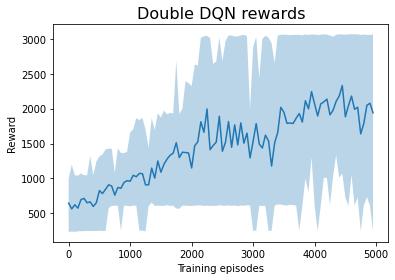

In [14]:
name_doubleDQN = "DoubleDQN_Classic"
doubleDQN_pd = pd.read_csv('DoubleDQN.csv',header = None)
pd_data = doubleDQN_pd
pd_data.columns = [name_doubleDQN]

pd_data = pd_data.reset_index()
bines = [(i) * 50 for i in list(range(101))]
bines_lab = [(i) * 50 for i in list(range(100))]
pd_data['binned'] = pd.cut(pd_data['index'], bins=bines, labels=bines_lab)
pd_data = pd_data.fillna(0)
datag = pd_data.groupby(['binned']).mean()
datag = datag.reset_index()
dataq_min = pd_data.groupby(['binned']).quantile(.10)
dataq_min = dataq_min.reset_index()
dataq_max = pd_data.groupby(['binned']).quantile(.90)
dataq_max = dataq_max.reset_index()

fig, ax = plt.subplots()
ax.plot(np.array(datag['binned']),np.array(datag[name_doubleDQN]))
ax.fill_between(datag['binned'], dataq_min[name_doubleDQN], dataq_max[name_doubleDQN], alpha=.3)

ax.set_xlabel("Training episodes")
ax.set_ylabel("Reward")

ax.set_title('Double DQN rewards', fontsize=16)

plt.show()

### See the agent in action!

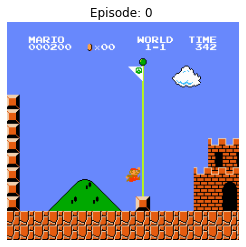

Average reward:  3063.0


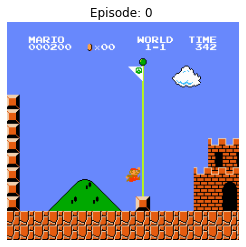

In [16]:
## Test without exploration - only model performance
test_rewards = agent.test(50,4000,False, eps_test = 0)
agent.test(1,4000,True)
print("Average reward: ", statistics.mean(test_rewards))